                                                             Capstone Project
                                                                (Group 2)

#                                                        Topic: Driver Drowsiness Detection 

# Drowsiness Detection using MAR

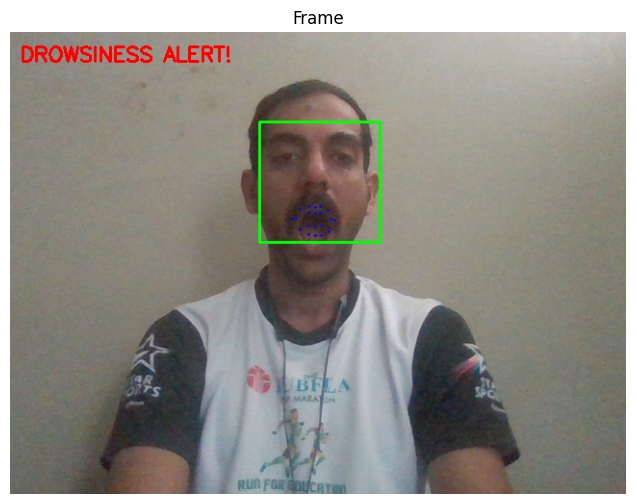

In [ ]:
from matplotlib import pyplot as plt
import cv2
import dlib
from scipy.spatial import distance as dist
from IPython.display import clear_output

def calculate_mar(mouth):
    # Compute the vertical mouth landmarks.
    A = dist.euclidean(mouth[2], mouth[10])  # 51, 59 in the Dlib 68 model
    B = dist.euclidean(mouth[4], mouth[8])   # 53, 57 in the Dlib 68 model
    C = dist.euclidean(mouth[0], mouth[6])   # 49, 55 in the Dlib 68 model
    mar = (A + B) / (2.0 * C)
    return mar

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector() # creates a frontal face detector
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # localizes specific coordinates on an input shape

cap = cv2.VideoCapture(0) # reading video files

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert an image from one color space to another
        rects = detector(gray, 0)

        for rect in rects:
            # Draw a rectangle around the face
            (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2) # draw a rectangle on an image
            
            shape = predictor(gray, rect)
            shape = [(shape.part(x).x, shape.part(x).y) for x in range(48, 68)]
            
            # Draw the facial landmarks
            for (x, y) in shape:
                cv2.circle(frame, (x, y), 1, (255, 0, 0), -1)
            
            mar = calculate_mar(shape)
            MAR_THRESHOLD = 0.51
            if mar > MAR_THRESHOLD:
                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30), # putting text to image
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) # adding font to an image

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display the image
        plt.figure(figsize=(10, 6))
        plt.imshow(frame_rgb)
        plt.title("Frame")
        plt.axis('off')
        plt.show()
        
        # Clear the output for the next frame
        clear_output(wait=True)
        
except KeyboardInterrupt:
    print("Stream stopped") # clear output of the cell
finally:
    cap.release() #close video files or capturing device

# Drowsiness Detection using EAR

In [2]:
import cv2
import dlib
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import threading

# Function to calculate the Eye Aspect Ratio (EAR)
def eye_aspect_ratio(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Load the dlib models for facial landmarks
detector = dlib.get_frontal_face_detector() # creates a frontal face detector
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat') # localizes specific coordinates on an input shape

# Setup the image widget using ipywidgets
image_widget = widgets.Image(format='jpeg', width=400, height=300) # to visualize an image in a widget format

# Function to update the image widget
def update_image(frame):
    _, encoded_image = cv2.imencode('.jpg', frame) # encodes an image in memory buffer
    image_widget.value = encoded_image.tobytes() # returns image as byte object

# Function to handle the camera feed and perform drowsiness detection
def camera_feed():
    camera = cv2.VideoCapture(0) # to read video files
    EAR_THRESHOLD = 0.25  # Adjust this threshold based on testing
    FRAMES_TO_CONFIRM_DROWSINESS = 1  # Number of consecutive frames with low EAR to confirm drowsiness
    frame_counter = 0  # Counter for consecutive frames
    try:
        while True:
            # Read a frame from the camera
            ret, frame = camera.read()
            if not ret:
                break

            # Convert the frame to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Detect faces in the grayscale frame
            faces = detector(gray)

            # Perform drowsiness detection if faces are detected
            for face in faces:
                x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                landmarks = predictor(gray, face)

                # Extract the left and right eye coordinates
                left_eye_pts = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
                right_eye_pts = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])

                # Draw landmarks for the left and right eye
                for n in range(36, 48):
                    x, y = landmarks.part(n).x, landmarks.part(n).y
                    cv2.circle(frame, (x, y), 1, (255, 0, 0), -1)

                # Calculate EAR for both eyes
                left_ear = eye_aspect_ratio(left_eye_pts)
                right_ear = eye_aspect_ratio(right_eye_pts)

                # Average the EAR from both eyes
                ear = (left_ear + right_ear) / 2.0

                if ear < EAR_THRESHOLD:
                    frame_counter += 1
                    if frame_counter >= FRAMES_TO_CONFIRM_DROWSINESS:
                        cv2.putText(frame, "DROWSINESS DETECTED", (10, 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                else:
                    frame_counter = 0

            # Update the image widget with the new frame
            update_image(frame)
    finally:
        camera.release() # closes video files or capturing device

# Display the image widget
display(image_widget)

# Start the camera feed in a separate thread
thread = threading.Thread(target=camera_feed) # to manage multiple threads off execution in a program
thread.start()

Image(value=b'', format='jpeg', height='300', width='400')

# Nodding and Shaking Detection

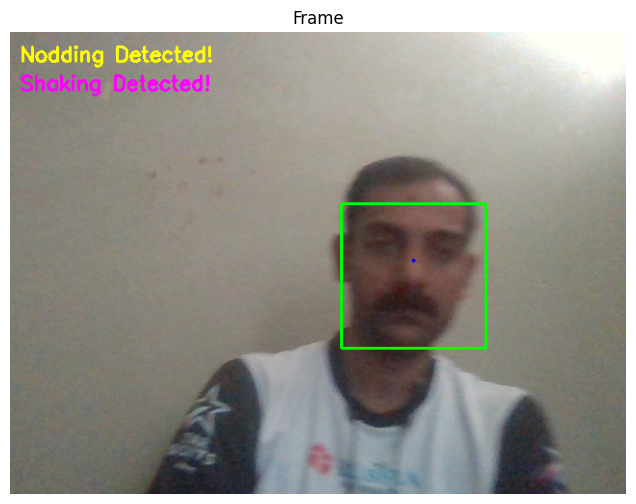

In [ ]:
from matplotlib import pyplot as plt
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from IPython.display import clear_output

def get_nose_center(shape):
    """Calculate the center point of the base of the nose."""
    nose_base = shape[27:31]  # Nose base points in Dlib 68 model
    nose_center = np.mean(nose_base, axis=0).astype(int)
    return (nose_center[0], nose_center[1])

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

cap = cv2.VideoCapture(0)

prev_nose_centers = []
MOVEMENT_THRESHOLD = 10
NUM_FRAMES_FOR_AVERAGE = 5

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape_points = [(shape.part(x).x, shape.part(x).y) for x in range(shape.num_parts)]
            shape_np = np.array(shape_points, dtype=np.int32)

            nose_center = get_nose_center(shape_np)
            prev_nose_centers.append(nose_center)

            # Only keep the last few centers
            prev_nose_centers = prev_nose_centers[-NUM_FRAMES_FOR_AVERAGE:]

            if len(prev_nose_centers) > 1:
                # Calculate movement over the last few frames
                movements = [np.array(prev_nose_centers[i]) - np.array(prev_nose_centers[i-1]) for i in range(1, len(prev_nose_centers))]
                average_movement = np.mean(movements, axis=0)
                vertical_movement = abs(average_movement[1])
                horizontal_movement = abs(average_movement[0])

                if vertical_movement > MOVEMENT_THRESHOLD:
                    frame = cv2.putText(frame, "Nodding Detected!", (10, 30),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                if horizontal_movement > MOVEMENT_THRESHOLD:
                    frame = cv2.putText(frame, "Shaking Detected!", (10, 60),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

            # Draw the center of the nose for debugging
            cv2.circle(frame, nose_center, 2, (255, 0, 0), -1)

            # Draw a rectangle around the face
            (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Convert BGR to RGB for matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display the image with matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(frame_rgb)
        plt.title("Frame")
        plt.axis('off')
        plt.show()
        
        # Clear the output for the next frame
        clear_output(wait=True)

except KeyboardInterrupt:
    print("Stream stopped.")
finally:
    cap.release()

# Integrating EAR, MAR and head nodding

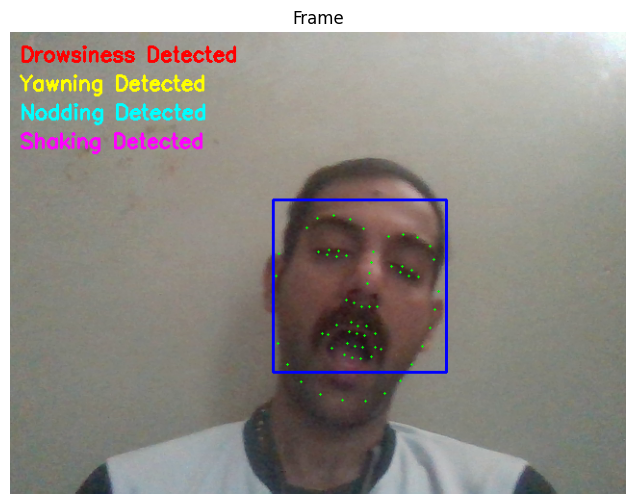

In [ ]:
from matplotlib import pyplot as plt
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from IPython.display import clear_output

def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    return (A + B) / (2.0 * C)

def get_nose_center(shape):
    nose_base = shape[27:31]
    return np.mean(nose_base, axis=0).astype(int)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

cap = cv2.VideoCapture(0)
prev_nose_center = None
EAR_THRESHOLD = 0.25
MAR_THRESHOLD = 0.5
VERTICAL_MOVEMENT_THRESHOLD = 10
HORIZONTAL_MOVEMENT_THRESHOLD = 10

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])
            nose_center = get_nose_center(shape_points)

            if prev_nose_center is not None:
                movement_vector = nose_center - prev_nose_center
                vertical_movement = abs(movement_vector[1])
                horizontal_movement = abs(movement_vector[0])

                if vertical_movement > VERTICAL_MOVEMENT_THRESHOLD:
                    cv2.putText(frame, "Nodding Detected", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
                if horizontal_movement > HORIZONTAL_MOVEMENT_THRESHOLD:
                    cv2.putText(frame, "Shaking Detected", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

            prev_nose_center = nose_center

            if ear < EAR_THRESHOLD:
                cv2.putText(frame, "Drowsiness Detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            if mar > MAR_THRESHOLD:
                cv2.putText(frame, "Yawning Detected", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            # Draw facial landmarks for debugging
            for (x, y) in shape_points:
                cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)
            cv2.rectangle(frame, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (255, 0, 0), 2)

        # Display the image
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(frame_rgb)
        plt.title("Frame")
        plt.axis('off')
        plt.show()
        
        clear_output(wait=True)
        
except KeyboardInterrupt:
    print("Stream stopped.")
finally:
    cap.release()

# Model creation using Random forest

Cross-validation scores: [0.65714286 0.76470588 0.67647059 0.52941176 0.73529412 0.73529412
 0.76470588 0.44117647 0.79411765 0.73529412]
Mean CV Score: 0.6834
Std CV Score: 0.1080
Classification report on test set:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        49
           1       0.71      0.54      0.62        37

    accuracy                           0.71        86
   macro avg       0.71      0.69      0.69        86
weighted avg       0.71      0.71      0.70        86



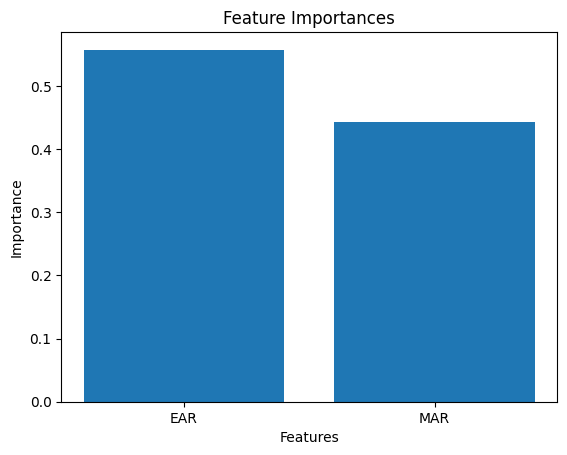

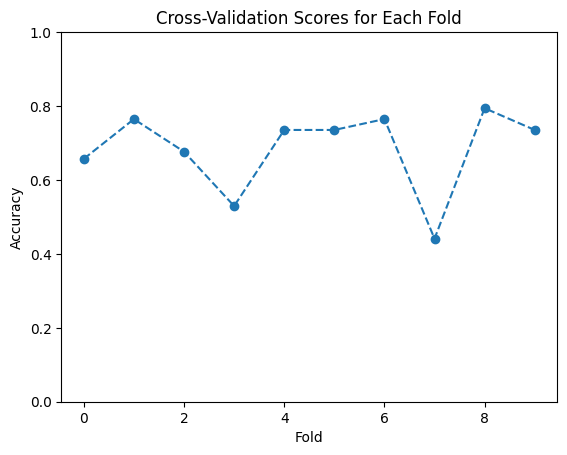

In [27]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import cv2
import dlib
from scipy.spatial import distance as dist
import joblib
import matplotlib.pyplot as plt


# Define EAR and MAR calculations
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Initialize dlib's face detector and facial landmark predictor
predictor_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Virtual_Env\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Function to extract features from an image file
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    if len(rects) == 0:
        return None, None
    shape = predictor(gray, rects[0])
    points = np.array([(p.x, p.y) for p in shape.parts()])
    ear = (calculate_ear(points[36:42]) + calculate_ear(points[42:48])) / 2.0
    mar = calculate_mar(points[48:68])
    return ear, mar

# Set the base path where the images and dataset are stored
base_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset"

# Load the dataset
df = pd.read_csv(os.path.join(base_path, 'Dataset.csv'))

# Update the 'filename' column with the full image paths
df['filename'] = df.apply(lambda row: os.path.join(base_path, row['label'], row['filename']), axis=1)

# Filter out non-image files
df = df[df['filename'].str.lower().str.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Extract EAR and MAR features for each image
features_list = []
for _, row in df.iterrows():
    ear, mar = extract_features(row['filename'])
    if ear is not None and mar is not None:
        features_list.append({'EAR': ear, 'MAR': mar, 'label': row['label']})

# Check if any features were extracted
if not features_list:
    raise ValueError("No features were extracted. Please check the dataset and image paths.")

# Create a DataFrame from the features
features_df = pd.DataFrame(features_list)

# Split the dataset into training and test sets
X = features_df[['EAR', 'MAR']]  # Features
y = features_df['label'].map({'awake': 0, 'drowsy': 1})  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
scaler_filename = os.path.join(base_path, 'scaler_filename.joblib')
joblib.dump(scaler, scaler_filename)

# Define and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=4, random_state=42)
model.fit(X_train_scaled, y_train)

# Perform cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

# Output cross-validation results
print("Cross-validation scores:", scores)
print(f"Mean CV Score: {np.mean(scores):.4f}")
print(f"Std CV Score: {np.std(scores):.4f}")

# Evaluate the model on the test set
y_pred_test = model.predict(X_test_scaled)
print("Classification report on test set:")
print(classification_report(y_test, y_pred_test))

# Save the trained model
model_filename = os.path.join(base_path, 'model_filename.joblib')
joblib.dump(model, model_filename)


# Assuming 'model' is your trained RandomForestClassifier
feature_importances = model.feature_importances_

# Simple plot
plt.bar(['EAR', 'MAR'], feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

# Cross-validation scores
plt.plot(scores, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores for Each Fold')
plt.ylim(0, 1)  # Assuming accuracy scores range from 0 to 1
plt.show()


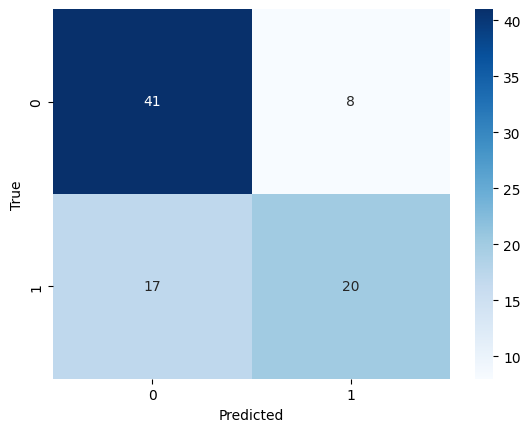

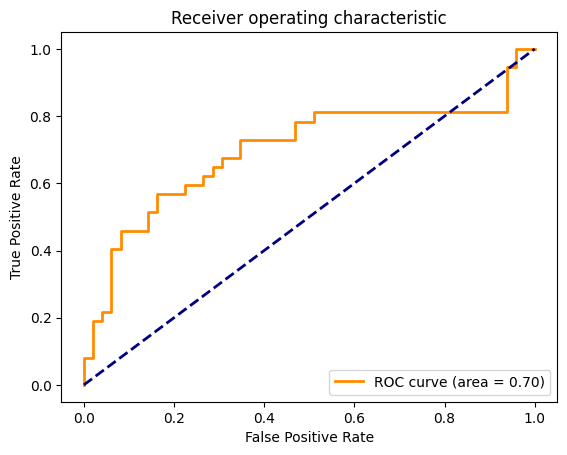

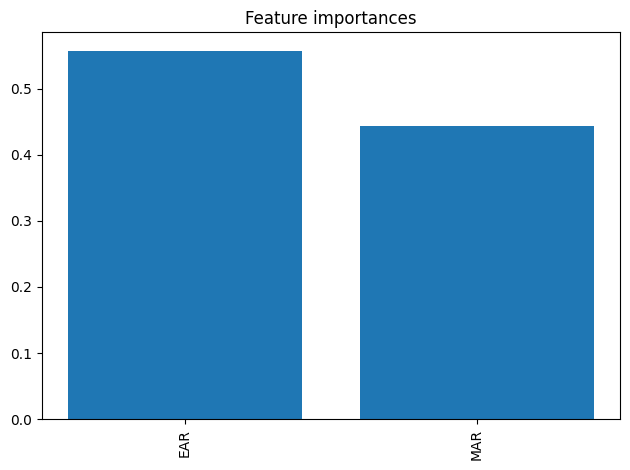

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plotting ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plotting feature importances
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title('Feature importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage:
y_pred = model.predict(X_test_scaled)
y_scores = model.predict_proba(X_test_scaled)[:, 1]  # Scores for ROC curve, typically for the positive class
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_scores)
plot_feature_importances(model, ['EAR', 'MAR'])

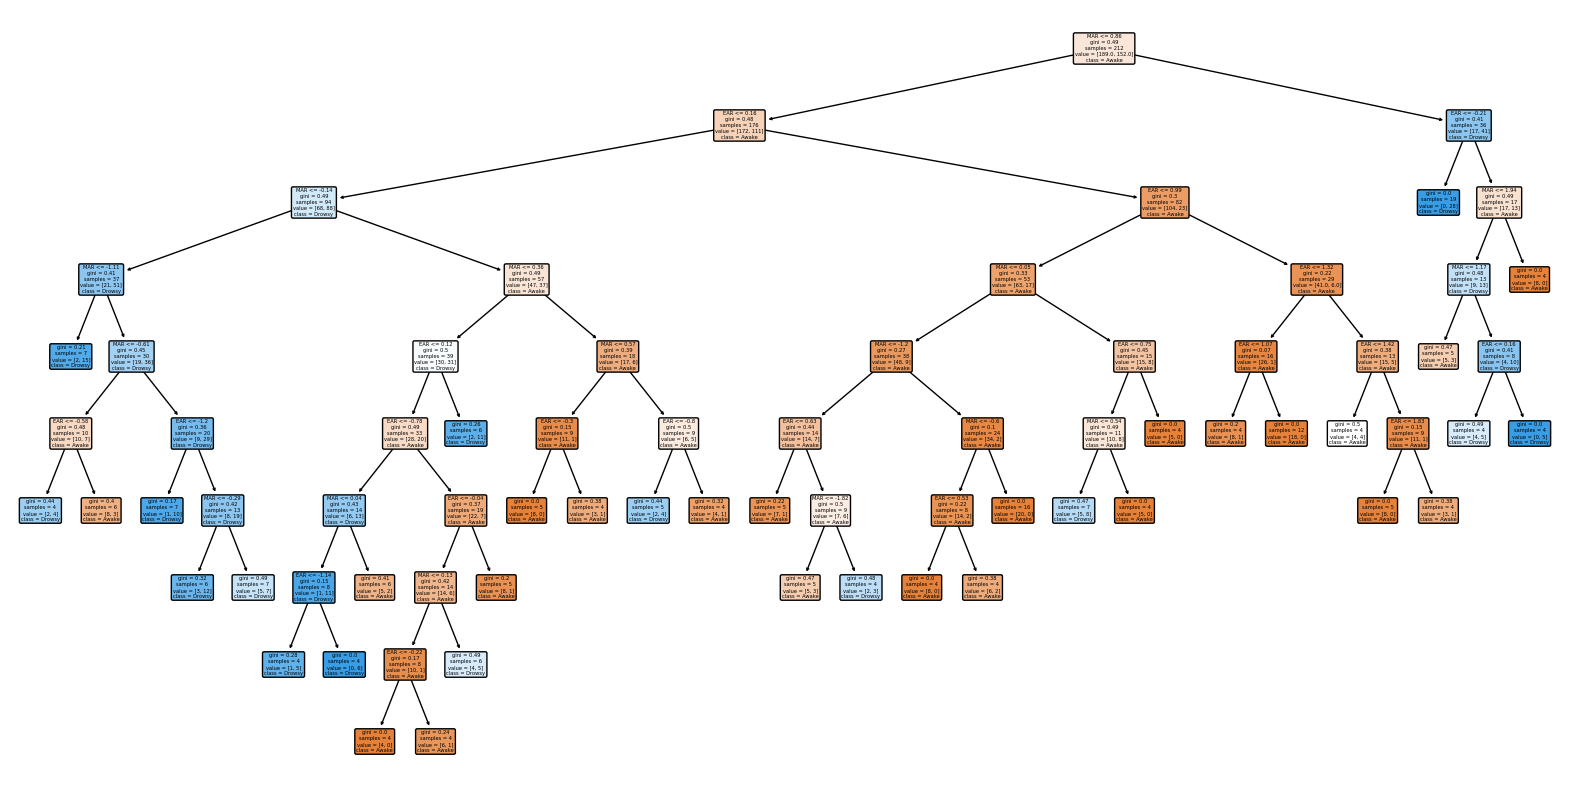

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Selecting the first tree from the forest
tree = model.estimators_[0]

# Plotting the decision tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=['EAR', 'MAR'], class_names=['Awake', 'Drowsy'], rounded=True, proportion=False, precision=2)
plt.show()

# Testing of Random Forest Model

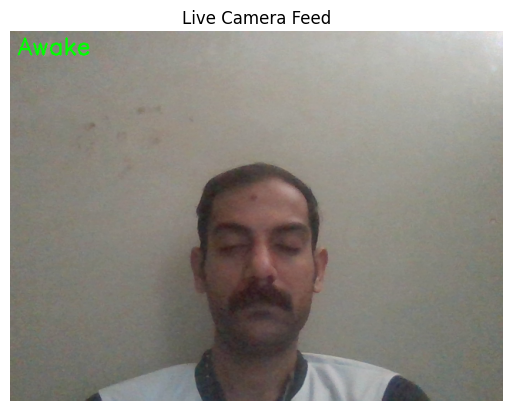

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
import joblib

# EAR calculation
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

# MAR calculation
def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Load the model and scaler
model = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\model_filename.joblib')  
scaler = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib') 

# Initialize dlib's face detector and facial landmark predictor
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Start the webcam feed
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        # Assume only one face per frame
        if rects:
            rect = rects[0]
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Calculate EAR and MAR
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            # Scale the features
            features = scaler.transform(np.array([[ear, mar]]))

            # Predict drowsiness
            prediction = model.predict(features)
            label = "Drowsy" if prediction == 1 else "Awake"
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)

        # Display the result in a Jupyter notebook
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Live Camera Feed')
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()
    display.clear_output(wait=True)import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
import joblib

# EAR calculation
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

# MAR calculation
def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Load the model and scaler
model = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\model_filename.joblib')  
scaler = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib') 

# Initialize dlib's face detector and facial landmark predictor
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Start the webcam feed
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        # Assume only one face per frame
        if rects:
            rect = rects[0]
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Calculate EAR and MAR
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            # Scale the features
            features = scaler.transform(np.array([[ear, mar]]))

            # Predict drowsiness
            prediction = model.predict(features)
            label = "Drowsy" if prediction == 1 else "Awake"
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)

        # Display the result in a Jupyter notebook
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Live Camera Feed')
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()
    display.clear_output(wait=True)
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
import joblib

# EAR calculation
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

# MAR calculation
def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Load the model and scaler
model = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\model_filename.joblib')  
scaler = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib') 

# Initialize dlib's face detector and facial landmark predictor
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Start the webcam feed
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        # Assume only one face per frame
        if rects:
            rect = rects[0]
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Calculate EAR and MAR
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            # Scale the features
            features = scaler.transform(np.array([[ear, mar]]))

            # Predict drowsiness
            prediction = model.predict(features)
            label = "Drowsy" if prediction == 1 else "Awake"
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)

        # Display the result in a Jupyter notebook
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Live Camera Feed')
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()
    display.clear_output(wait=True)import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
import joblib

# EAR calculation
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

# MAR calculation
def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Load the model and scaler
model = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\model_filename.joblib')  
scaler = joblib.load('E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib') 

# Initialize dlib's face detector and facial landmark predictor
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Start the webcam feed
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        # Assume only one face per frame
        if rects:
            rect = rects[0]
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Calculate EAR and MAR
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            # Scale the features
            features = scaler.transform(np.array([[ear, mar]]))

            # Predict drowsiness
            prediction = model.predict(features)
            label = "Drowsy" if prediction == 1 else "Awake"
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)

        # Display the result in a Jupyter notebook
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Live Camera Feed')
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    cv2.destroyAllWindows()
    display.clear_output(wait=True)

# Neural Network model Creation and Training

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2
import dlib
from scipy.spatial import distance as dist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import joblib

# Define EAR and MAR calculations
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar
    
# Initialize dlib's face detector and facial landmark predictor
predictor_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Virtual_Env\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Function to extract features from an image file
def extract_features(image_path):
    # Your image feature extraction code

    image = cv2.imread(image_path)
    if image is None:
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    if len(rects) == 0:
        return None, None
    shape = predictor(gray, rects[0])
    points = np.array([(p.x, p.y) for p in shape.parts()])
    ear = (calculate_ear(points[36:42]) + calculate_ear(points[42:48])) / 2.0
    mar = calculate_mar(points[48:68])
    return ear, mar

# Set the base path where the images and dataset are stored
base_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset"

# Load the dataset
df = pd.read_csv(os.path.join(base_path, 'Dataset.csv'))

# Update the 'filename' column with the full image paths
df['filename'] = df.apply(lambda row: os.path.join(base_path, row['label'], row['filename']), axis=1)

# Filter out non-image files
df = df[df['filename'].str.lower().str.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Extract EAR and MAR features for each image
features_list = []
for _, row in df.iterrows():
    ear, mar = extract_features(row['filename'])
    if ear is not None and mar is not None:
        features_list.append({'EAR': ear, 'MAR': mar, 'label': row['label']})

# Check if any features were extracted
if not features_list:
    raise ValueError("No features were extracted. Please check the dataset and image paths.")

# Create a DataFrame from the features
features_df = pd.DataFrame(features_list)

# Split the dataset into training and test sets
X = features_df[['EAR', 'MAR']]  # Features
y = features_df['label'].map({'awake': 0, 'drowsy': 1})  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
scaler_filename = os.path.join(base_path, 'scaler_filename.joblib')
joblib.dump(scaler, scaler_filename)

# Define the Keras model
model_nn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Using Input layer as suggested
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the model
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_nn.fit(X_train_scaled, y_train, validation_split=0.1, epochs=50, batch_size=16, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model_nn.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

# Save the neural network model
model_filename = os.path.join(base_path, 'drowsiness_detection_model.h5')
model_nn.save(model_filename)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5920 - loss: 0.6780 - val_accuracy: 0.6857 - val_loss: 0.5985
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6066 - loss: 0.6468 - val_accuracy: 0.6857 - val_loss: 0.5758
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6690 - loss: 0.6145 - val_accuracy: 0.6857 - val_loss: 0.5610
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6298 - loss: 0.6369 - val_accuracy: 0.6857 - val_loss: 0.5773
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6948 - loss: 0.5938 - val_accuracy: 0.6857 - val_loss: 0.5779
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6643 - loss: 0.5929 - val_accuracy: 0.6857 - val_loss: 0.5912
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6571 - loss: 0.6092 - val_accuracy: 0.6857 - val_loss: 0.5907
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6249 - loss: 0.6136 - val_accuracy: 0.7143 - val_loss

Test loss: 0.556, Test accuracy: 0.698


In [2]:
model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,261 (126.02 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,508 (84.02 KB)

In [8]:
from tensorflow.keras.utils import model_to_dot

dot_model = model_to_dot(model_nn, show_shapes=True, show_layer_names=True)

output_dot_file_path = "E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\\model_graph.dot"

with open(output_dot_file_path, "w") as dot_file:
    dot_file.write(dot_model.to_string())


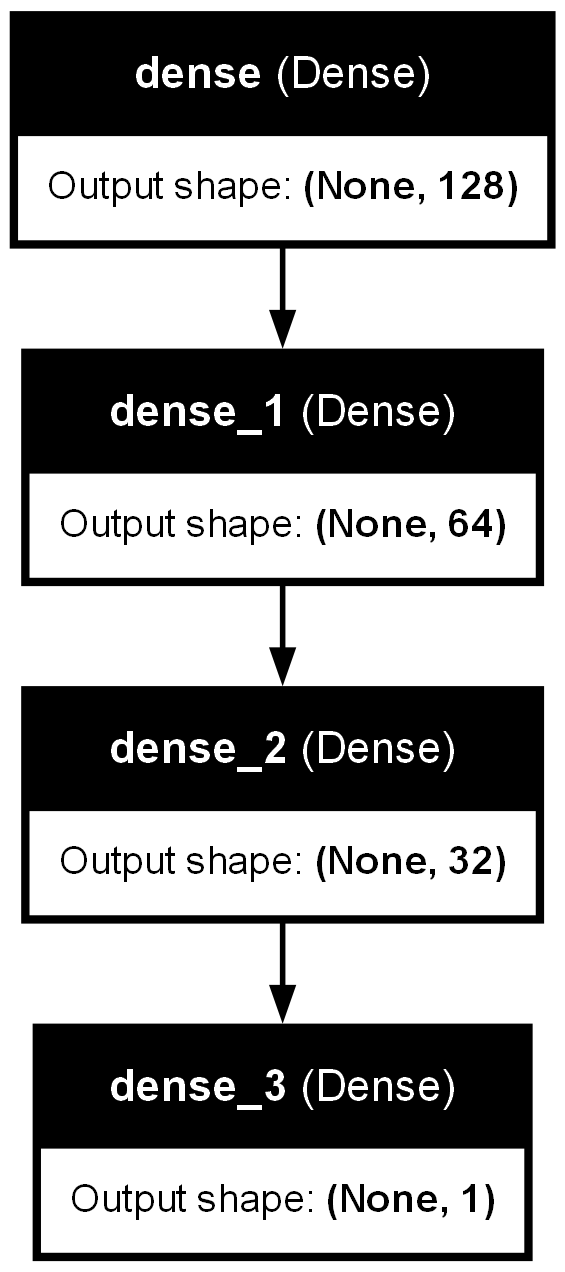

In [10]:
from IPython.display import Image
# Display the generated PNG
Image(filename='E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\\model_graph.png')

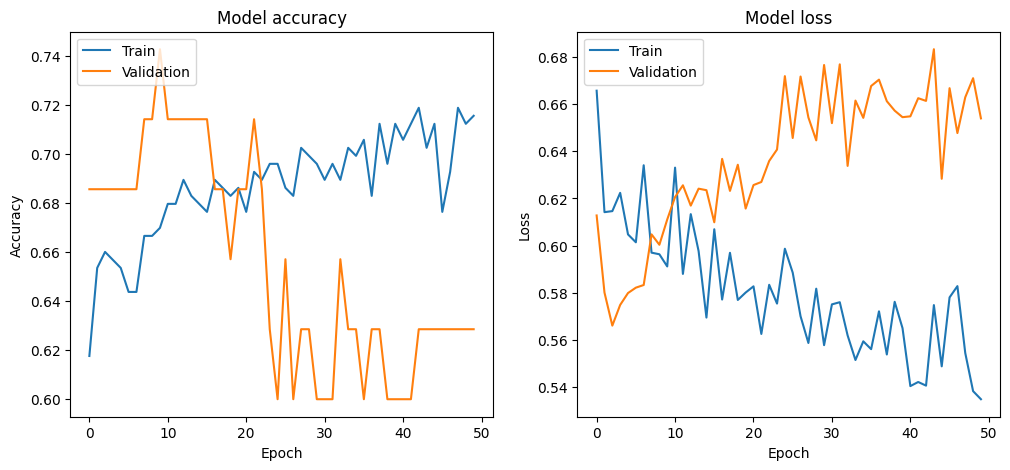

In [4]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Testing of Model based on Neural Network

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from tensorflow.keras.models import load_model
import joblib

# Define EAR and MAR calculations
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Load the model and scaler
model_path = r'E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\drowsiness_detection_model.h5' 
scaler_path = r'E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib'  
model_nn = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize dlib's face detector and facial landmark predictor
predictor_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Virtual_Env\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Start the webcam feed
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Draw facial landmarks
            for (x, y) in shape_points:
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)  # Draw green dots for landmarks
            
            # Draw rectangle around the face
            (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw blue rectangle for face boundary
            
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            # Scale the features
            features = np.array([[ear, mar]])
            features_scaled = scaler.transform(features)

            # Predict drowsiness
            prediction_prob = model_nn.predict(features_scaled)
            prediction = (prediction_prob > 0.5).astype(int)
            label = "Drowsy" if prediction[0, 0] == 1 else "Awake"

            # Overlay the label on the frame
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)

        # Convert BGR to RGB for matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the image with matplotlib
        plt.imshow(frame_rgb)
        plt.title('Live Camera Feed')
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    cap.release()
    plt.close()

# Testing of Model based on Neural Network with Nodding and Shaking

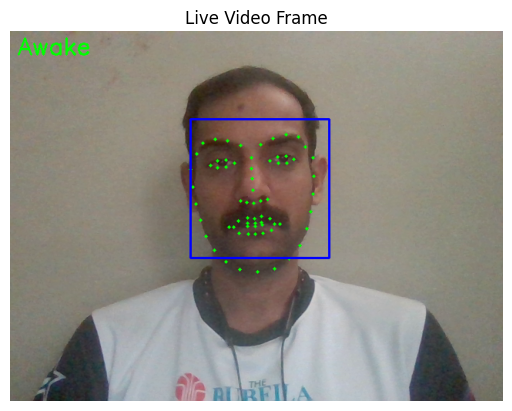

D:\LoyalistCollege_Semester_One_StudyWorks\Semester_2\AIGS1012_Professional Portfolio\Virtual_Env\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from tensorflow.keras.models import load_model
import joblib

# Define EAR and MAR calculations
def calculate_ear(eye_points):
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Function to get the center of the nose base
def get_nose_center(shape):
    nose_base = shape[27:31]
    return np.mean(nose_base, axis=0).astype(int)

# Load the model and scaler
model_path = r'E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\drowsiness_detection_model.h5' 
scaler_path = r'E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib'
model_nn = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize dlib's face detector and facial landmark predictor
predictor_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Virtual_Env\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Start the webcam feed
cap = cv2.VideoCapture(0)
prev_nose_centers = []
MOVEMENT_THRESHOLD = 10
NUM_FRAMES_FOR_AVERAGE = 5

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Draw facial landmarks
            for (x, y) in shape_points:
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)  # Draw green dots for landmarks
            
            # Draw rectangle around the face
            (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw blue rectangle for face boundary
            
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            features = np.array([[ear, mar]])
            features_scaled = scaler.transform(features)

            prediction_prob = model_nn.predict(features_scaled)
            prediction = (prediction_prob > 0.5).astype(int)
            label = "Drowsy" if prediction[0, 0] == 1 else "Awake"
            
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)
            
            # Detection for nodding and shaking
            nose_center = get_nose_center(shape_points)
            prev_nose_centers.append(nose_center)

            prev_nose_centers = prev_nose_centers[-NUM_FRAMES_FOR_AVERAGE:]

            if len(prev_nose_centers) > 1:
                movements = [np.array(prev_nose_centers[i]) - np.array(prev_nose_centers[i-1]) for i in range(1, len(prev_nose_centers))]
                average_movement = np.mean(movements, axis=0)
                vertical_movement = abs(average_movement[1])
                horizontal_movement = abs(average_movement[0])

                if vertical_movement > MOVEMENT_THRESHOLD:
                    cv2.putText(frame, "Nodding Detected", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
                if horizontal_movement > MOVEMENT_THRESHOLD:
                    cv2.putText(frame, "Shaking Detected", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

        # Convert BGR to RGB for matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the image with matplotlib
        plt.imshow(frame_rgb)
        plt.title("Live Video Frame")
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    cap.release()
    plt.close()

# Neural Network model Creation and Training (Revised the Neural network model)

In [32]:
import cv2
import os
import dlib
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

def calculate_ear(eye_points):
    """Calculate the Eye Aspect Ratio (EAR) for blink detection."""
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
    """Calculate the Mouth Aspect Ratio (MAR) for yawn detection."""
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    return (A + B) / (2.0 * C)

def extract_features(df, detector, predictor, base_path):
    """Extract EAR and MAR features from each image listed in the dataframe."""
    features_list = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_path, row['label'], row['filename'])
        image = cv2.imread(image_path)
        if image is None:
            continue
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)
        for rect in rects:
            shape = predictor(gray, rect)
            points = np.array([(p.x, p.y) for p in shape.parts()])
            ear = (calculate_ear(points[36:42]) + calculate_ear(points[42:48])) / 2.0
            mar = calculate_mar(points[48:68])
            features_list.append({'EAR': ear, 'MAR': mar, 'label': row['label']})
    return pd.DataFrame(features_list)

# Load dataset and initialize feature extraction tools
base_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset"
df = pd.read_csv(os.path.join(base_path, 'Dataset.csv'))


predictor_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Virtual_Env\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Extract features and prepare data
features_df = extract_features(df, detector, predictor, base_path)
X = features_df[['EAR', 'MAR']]
y = features_df['label'].map({'awake': 0, 'drowsy': 1})
scaler = StandardScaler() # standardizing input data by removing the mean and scalling it to have unit variance
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

scaler_filename = "scaler_filename.joblib"
joblib.dump(scaler, scaler_filename)

# Define and train neural network
model_nn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'), Dropout(0.5), BatchNormalization(),
    Dense(64, activation='relu'), Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare callbacks
checkpoint = ModelCheckpoint('best_model.tf', monitor='val_loss', verbose=1, save_best_only=True, mode='min') # saving model at some instance, such that the model can be loaded later to continue the training from the state saved
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1) # callback used while training the neural network, which provides us the advantage of using a large number of training epochs and stopping the training once the models performance stops improving on the validation Dataset

# Train the model
history = model_nn.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_accuracy:.3f}")

# Generate a classification report
y_pred = (model_nn.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['Awake', 'Drowsy']))

# Save the trained model
model_nn.save("drowsiness_detection_model.h5")

Epoch 1/50
 9/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5815 - loss: 0.7115 
Epoch 1: val_loss improved from inf to 0.67247, saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5697 - loss: 0.7109 - val_accuracy: 0.6860 - val_loss: 0.6725
Epoch 2/50
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5241 - loss: 0.6846 
Epoch 2: val_loss improved from 0.67247 to 0.66036, saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5370 - loss: 0.6872 - val_accuracy: 0.6628 - val_loss: 0.6604
Epoch 3/50
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6734 - loss: 0.6209 
Epoch 3: val_loss improved from 0.66036 to 0.65626, saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6613 - loss: 0.6304 - val_accuracy: 0.6744 - val_loss: 0.6563
Epoch 4/50
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6534 - loss: 0.6322 
Epoch 4: val_loss improved from 0.65626 to 0.65094, saving mode

              precision    recall  f1-score   support

       Awake       0.70      0.88      0.78        48
      Drowsy       0.77      0.53      0.62        38

    accuracy                           0.72        86
   macro avg       0.73      0.70      0.70        86
weighted avg       0.73      0.72      0.71        86



In [33]:
# After defining and compiling model_nn
model_nn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,285 (130.02 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 22,020 (86.02 KB)

In [34]:
from tensorflow.keras.utils import model_to_dot

dot_model = model_to_dot(model_nn, show_shapes=True, show_layer_names=True)

output_dot_file_path = "D:\\LoyalistCollege_Semester_One_StudyWorks\\Semester_2\\AIGS1012_Professional Portfolio\\Project_Documents and Installation Files\\Driver_Drowsiness\\Dataset\\model_graph.dot"

with open(output_dot_file_path, "w") as dot_file:
    dot_file.write(dot_model.to_string())

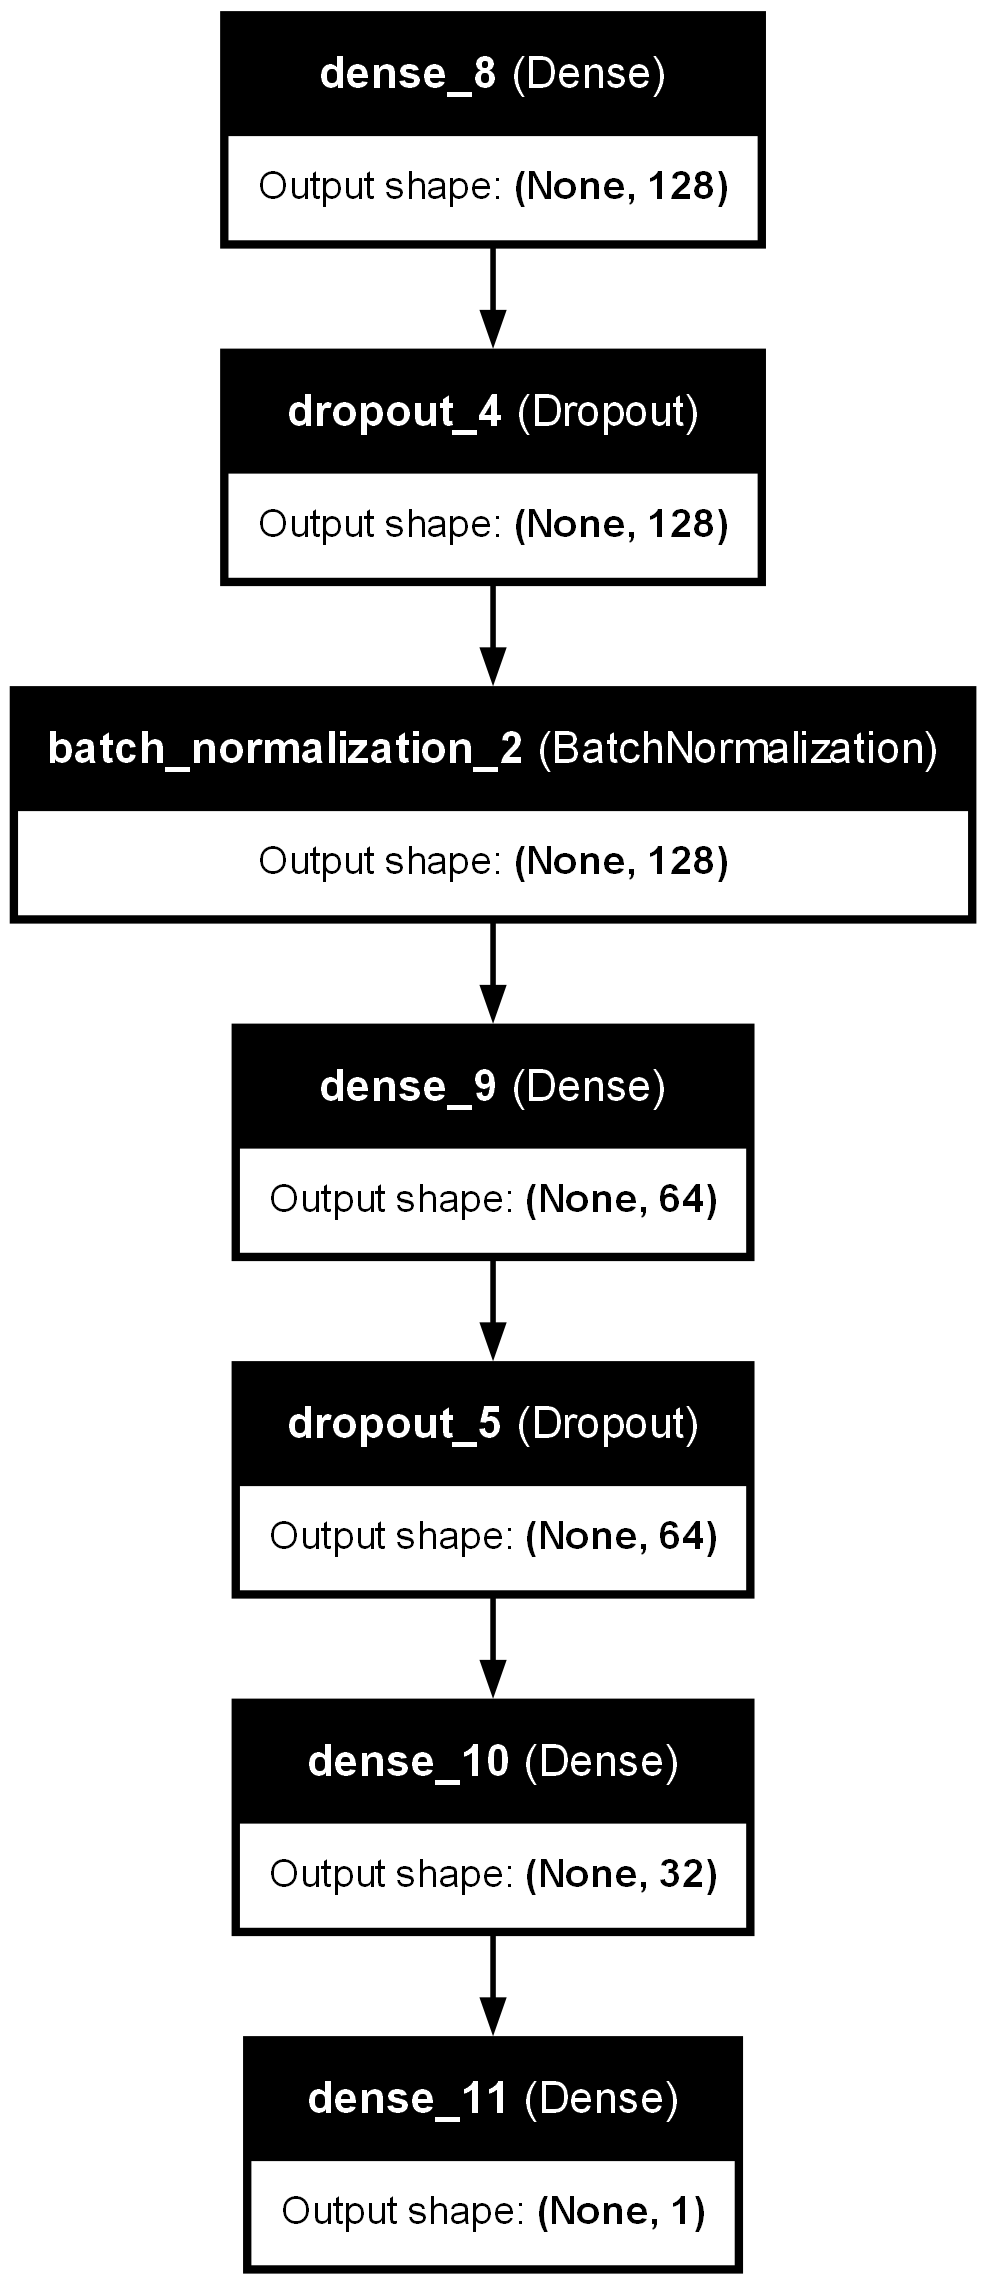

In [35]:
from IPython.display import Image

Image(filename='D:\\LoyalistCollege_Semester_One_StudyWorks\\Semester_2\\AIGS1012_Professional Portfolio\\Project_Documents and Installation Files\\Driver_Drowsiness\\Dataset\\model_graph.png')

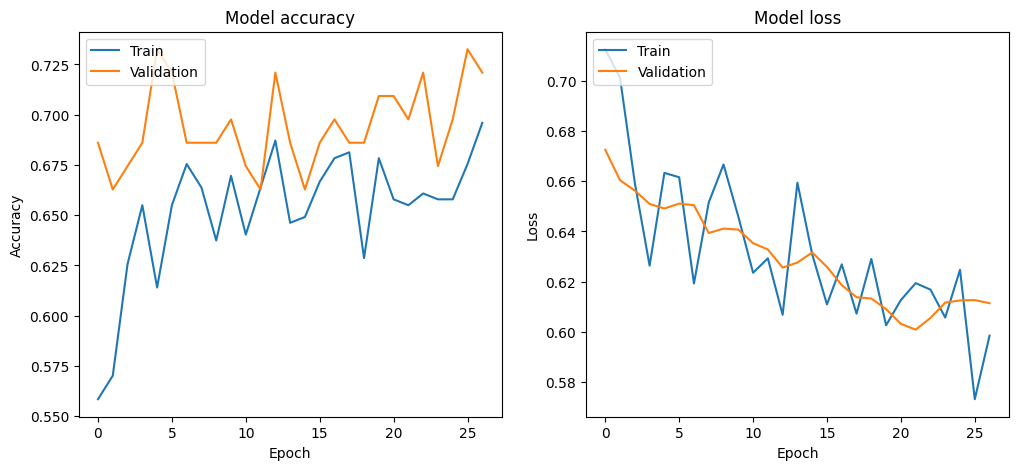

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [1]:
import pyttsx3
engine = pyttsx3.init()

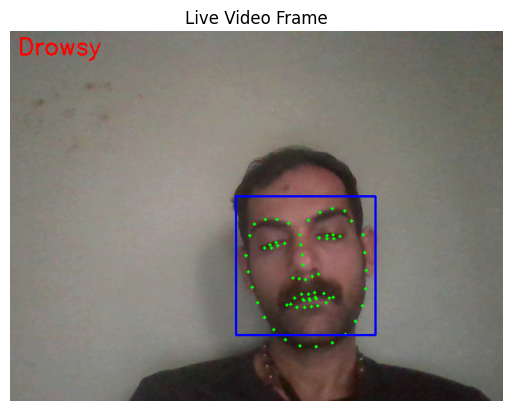

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


D:\LoyalistCollege_Semester_One_StudyWorks\Semester_2\AIGS1012_Professional Portfolio\Virtual_Env\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from tensorflow.keras.models import load_model
import joblib
import pyttsx3
engine = pyttsx3.init()

# Define EAR and MAR calculations
def calculate_ear(eye_points):
    # calculating the length of a vector
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def calculate_mar(mouth_points):
     # calculating the length of a vector
    A = dist.euclidean(mouth_points[2], mouth_points[10])
    B = dist.euclidean(mouth_points[4], mouth_points[8])
    C = dist.euclidean(mouth_points[0], mouth_points[6])
    mar = (A + B) / (2.0 * C)
    return mar

# Function to get the center of the nose base
def get_nose_center(shape):
    nose_base = shape[27:31] # returns the shape of an array
    return np.mean(nose_base, axis=0).astype(int) # computing arithematic mean

# Load the model and scaler
model_path = r'E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\drowsiness_detection_model.h5' 
scaler_path = r'E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Dataset\scaler_filename.joblib'
model_nn = load_model(model_path)
scaler = joblib.load(scaler_path)

# Initialize dlib's face detector and facial landmark predictor
predictor_path = r"E:\Artificial Intelligence and Data Science - Loyalist College\AIGS Semester 2\AIGS 1014 Capstone Project\Virtual_Env\shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector() # creates a frontal face detector
predictor = dlib.shape_predictor(predictor_path) # localizes specific coordinates on an input shape

# Start the webcam feed
cap = cv2.VideoCapture(0)
prev_nose_centers = []
MOVEMENT_THRESHOLD = 10
NUM_FRAMES_FOR_AVERAGE = 5

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            shape = predictor(gray, rect)
            shape_points = np.array([(shape.part(x).x, shape.part(x).y) for x in range(68)], dtype=np.int32)

            # Draw facial landmarks
            for (x, y) in shape_points:
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)  # Draw green dots for landmarks
            
            # Draw rectangle around the face
            (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw blue rectangle for face boundary
            
            ear = (calculate_ear(shape_points[36:42]) + calculate_ear(shape_points[42:48])) / 2.0
            mar = calculate_mar(shape_points[48:68])

            features = np.array([[ear, mar]])
            features_scaled = scaler.transform(features) # transform given features using a scalling technique

            prediction_prob = model_nn.predict(features_scaled) # predicting the labels for new data of drowsiness
            prediction = (prediction_prob > 0.5).astype(int) 
            label = "Drowsy" 
            if prediction[0, 0] == 1:
                engine.say("Attention:You appear to be drowsy. Please consider taking a break") 
                engine.runAndWait() 
            else: 
                label = "Awake"
            
            cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if prediction == 1 else (0, 255, 0), 2)
            
            # Detection for nodding and shaking
            nose_center = get_nose_center(shape_points)
            prev_nose_centers.append(nose_center)

            prev_nose_centers = prev_nose_centers[-NUM_FRAMES_FOR_AVERAGE:]

            if len(prev_nose_centers) > 1:
                movements = [np.array(prev_nose_centers[i]) - np.array(prev_nose_centers[i-1]) for i in range(1, len(prev_nose_centers))]
                average_movement = np.mean(movements, axis=0)
                vertical_movement = abs(average_movement[1]) # returns absolute value
                horizontal_movement = abs(average_movement[0]) # returns absolute value

                if vertical_movement > MOVEMENT_THRESHOLD:
                    cv2.putText(frame, "Nodding Detected", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
                if horizontal_movement > MOVEMENT_THRESHOLD:
                    cv2.putText(frame, "Shaking Detected", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

        # Convert BGR to RGB for matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the image with matplotlib
        plt.imshow(frame_rgb)
        plt.title("Live Video Frame")
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()

except KeyboardInterrupt:
    cap.release()
    plt.close()
